[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/face_detection.ipynb)

# Face Detection and blurring

In this tutorials we will show how to use
- The [Face Detection](https://kornia.readthedocs.io/en/latest/applications/face_detection.html) API in CPU/GPU.
- Blur the detected images.

In [1]:
%%capture
!pip install git+https://github.com/kornia/kornia

In [2]:
%%capture
!wget -O image.jpg https://www.reader.gr/sites/default/files/styles/schema_cover_1_1/public/2021-09/squid-game-3.jpg

Import the needed libraries

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import kornia as K
from kornia.contrib import FaceDetector, FaceDetectorResult

# select the device and type
device = torch.device('cpu')  # use 'cuda:0'
dtype = torch.float32

Read the image and convert to a `torch.Tensor`

In [17]:
# load the image and scale (if needed)
img_raw = cv2.imread('image.jpg', cv2.IMREAD_COLOR)

# preprocess
img = K.image_to_tensor(img_raw, keepdim=False).to(device, dtype)
img = K.color.bgr_to_rgb(img)

img_vis = K.tensor_to_image(img.byte().clone())  # to later visualise

(-0.5, 1199.5, 1199.5, -0.5)

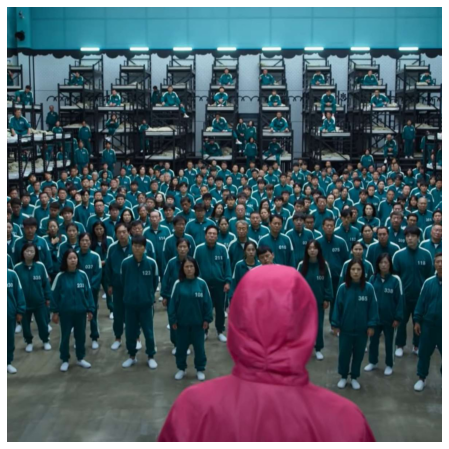

In [18]:
plt.figure(figsize=(8, 8))
plt.imshow(K.tensor_to_image(img.byte()))
plt.axis('off')

Create the [FaceDetector](https://kornia.readthedocs.io/en/latest/contrib.html#kornia.contrib.FaceDetector) object and apply to the image

In [19]:
# create the detector and find the faces !
face_detection = FaceDetector().to(device, dtype)

with torch.no_grad():
    dets = face_detection(img)

# to decode later the detections
dets = [FaceDetectorResult(o) for o in dets]

Create a function to crop the faces from the original image and apply blurring using the [gaussian_blurd2d](https://kornia.readthedocs.io/en/latest/filters.html?highlight=gaussian%20blur#kornia.filters.gaussian_blur2d) operator.

Alternatively, explore other blur operator in [`kornia.filters`](https://kornia.readthedocs.io/en/latest/filters.html).

In [20]:
# blurring paramters
k: int = 21     # kernel_size
s: float = 35.  # sigma

def apply_blur_face(img: torch.Tensor, img_vis: np.ndarray, det: FaceDetectorResult):
    # crop the face
    x1, y1 = det.xmin.int(), det.ymin.int()
    x2, y2 = det.xmax.int(), det.ymax.int()
    roi = img[..., y1:y2, x1:x2]

    # apply blurring and put back to the visualisation image
    roi = K.filters.gaussian_blur2d(roi, (k, k), (s, s))
    roi = K.color.rgb_to_bgr(roi)
    img_vis[y1:y2, x1:x2] = K.tensor_to_image(roi)

Let draw the detections and save/visualize the image

True

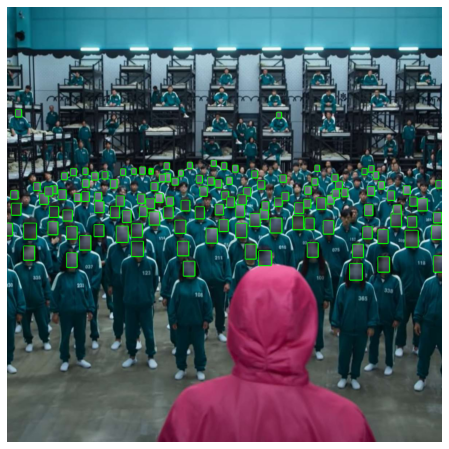

In [25]:
for b in dets:
    if b.score < 0.6:  # skip detections with lower score
        continue
    
    # draw face bounding box around each detected face
    x1, y1 = b.top_left.int().tolist()
    x2, y2 = b.bottom_right.int().tolist()
    img_vis = cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 4)

    # blur the detected faces
    apply_blur_face(img, img_vis, b)

plt.figure(figsize=(8, 8))
plt.imshow(img_vis)
plt.axis('off')

# save and show image
cv2.imwrite('img_out.jpg', img_vis)

## Play with the Real Time Demo

You can achieve 60 FPS in CPU using a standard WebCam.

See: [https://github.com/kornia/kornia/blob/master/examples/face_detection/main_video.py](https://github.com/kornia/kornia/blob/master/examples/face_detection/main_video.py)

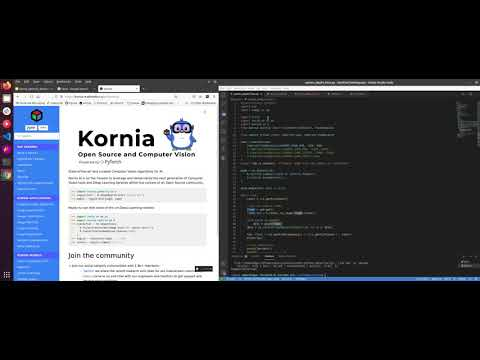

In [30]:
from IPython.display import YouTubeVideo
YouTubeVideo('hzQroGp5FSQ')